In [9]:
import os
os.chdir("/Users/praveen/MSDS/Data_Science_Practicum/FinGlobe_Project/FinGlobeModule/")
os.getcwd()

'/Users/praveen/MSDS/Data_Science_Practicum/FinGlobe_Project/FinGlobeModule'

In [21]:
# !pip install openai

In [ ]:
import re, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,4)
print("CWD :", os.getcwd())

# TEXTS_PATH = "/Users/praveen/MSDS/Data_Science_Practicum/FinGlobe_Project/FinGlobeModule/cache/scrapped_data/mpc_minutes_20200101_20241231.json"
TEXTS_PATH = "./scrapped_data/mpc_minutes_20200101_20241231.json"
SCORES_OUT = "./analysis_results/mpc_scores.json"

from src.mcp_project.tools.stance_scorer_eda import score_all

with open(TEXTS_PATH) as f:
    raw = json.load(f)   # {date: text}


CWD : /Users/praveen/MSDS/Data_Science_Practicum/FinGlobe_Project/FinGlobeModule


In [41]:
with open(TEXTS_PATH, "r", encoding="utf-8") as f:
    raw = json.load(f)

df_text = (pd.DataFrame(list(raw.items()), columns=["date","text"])
           .assign(date=lambda d: pd.to_datetime(d["date"], errors="coerce"))
           .dropna(subset=["date"])
           .sort_values("date")
           .reset_index(drop=True))
print(f"Records: {len(df_text)} | Range: {df_text.date.min().date()} → {df_text.date.max().date()}")

# optional: only last 2y based on max date in the file
cutoff = df_text["date"].max() - pd.DateOffset(years=3)
df_text = df_text[df_text["date"] >= cutoff].copy()
print(f"After 2y filter: {len(df_text)} rows")

Records: 35 | Range: 2020-09-17 → 2024-12-19
After 2y filter: 24 rows


# compute hawkish/dovish scores via your stance_scorer.py
- insight: explain ensemble mean (tone) and σ (model uncertainty/dispersion).

In [42]:
from src.mcp_project.tools.stance_scorer_eda import score_all  # or stance_scorer_eda if that’s your file

# n_runs=100 for production; using 5 here for speed
scores = score_all(TEXTS_PATH, SCORES_OUT, n_runs=5, pause_each=0.0)




In [43]:
df_score = (pd.DataFrame([{"date": k, **v} for k,v in scores.items()])
            .assign(date=lambda d: pd.to_datetime(d["date"]))
            .sort_values("date").reset_index(drop=True))

df = df_text.merge(df_score, on="date", how="left")
df["word_count"] = df["text"].str.split().str.len()
df.head(2)

,date,text,mean,std,scores,stance,rationale,word_count
0,2022-02-03,"Monetary Policy Summary, February 2022\nThe Ba...",0.7,0.0,"[0.7, 0.7, 0.7, 0.7, 0.7]",hawkish,The MPC's decision to increase the Bank Rate a...,1297
1,2022-03-17,"Monetary Policy Summary, March 2022\nThe Bank ...",0.4,0.0,"[0.4, 0.4, 0.4, 0.4, 0.4]",neutral,The MPC's decision to increase the Bank Rate a...,964


# Parse factual policy cues from the text
- Goal: extract Bank Rate, CPI(Consumer Price Index), and decision (cut/hold/hike) with light regex.
- Insight: this anchors tone to observable policy context (rate level, CPI, action).

#### Misc:
CPI measures inflation — the percentage change in average prices of goods and services over time.

#### Why it matters:
- The BoE’s target = 2% CPI inflation.
- So, whenever CPI is above 2%, the MPC’s tone tends to be hawkish (concerned about overheating).
- When CPI falls below 2%, tone leans dovish (worrying about weak demand or disinflation).

#### Bank Rate
##### Definition: The official policy interest rate set by the Bank of England’s Monetary Policy Committee (MPC).
It’s the rate the BoE pays commercial banks on reserves — effectively the anchor for short-term borrowing costs in the economy.

#### Why it matters:
- It’s the primary policy instrument used to tighten or loosen monetary conditions.
- When the MPC raises the Bank Rate, it signals hawkish (anti-inflation) stance.
- When it cuts the rate, it signals dovish (growth-supportive) stance.
- Holding steady usually indicates a neutral or “wait-and-see” approach.

#### Insight use: 
Lets you test: Does the LLM’s hawkish tone rise before rate hikes? (which would validate it captures forward guidance).

# Decision (cut / hold / hike)
##### Definition:
The MPC’s action outcome at each meeting — whether it raised, cut, or held the Bank Rate.

#### Why it matters:
- It’s the single clearest indicator of policy stance:
- Hike → tightening → hawkish.
- Cut → easing → dovish.
- Hold → neutral / wait-and-see.

#### Insight use:
Helps validate if your LLM’s tone classification aligns with actual MPC actions.

#### For example:
If the LLM’s mean score is highest in “hike” meetings and lowest in “cut” ones, the model is interpreting tone realistically.

In [44]:
def find_rate(t):
    m = re.search(r'Bank Rate.*?(?:to|at)\s*([0-9.]+)\s*%', t, re.I)
    return float(m.group(1)) if m else np.nan

def find_cpi(t):
    m = re.search(r'CPI inflation.*?([0-9.]+)\s*%', t, re.I)
    return float(m.group(1)) if m else np.nan

def find_decision(t):
    if re.search(r'\b(increase|raise)\b', t, re.I): return "hike"
    if re.search(r'\b(reduce|cut|lower)\b', t, re.I): return "cut"
    if re.search(r'\b(maintain|keep|hold)\b', t, re.I): return "hold"
    return "unknown"

df["bank_rate"] = df["text"].apply(find_rate)
df["cpi"]       = df["text"].apply(find_cpi)
df["decision"]  = df["text"].apply(find_decision)


# Track uncertainty & verbosity
- Goal: quick proxies for policy hesitation and communication intensity.
- Insight: spikes in uncertainty words and longer statements often coincide with close votes or regime shifts.

In [45]:
UNC = r"(uncertainty|risk|volatile|monitor|tension|shock|geopolitical)"
df["uncert_count"] = df["text"].str.count(UNC, flags=re.I)


# Goal: show tone trajectory, uncertainty, and length over meetings.
#### insight:
- Mean up = hawkish shift; down = dovish shift.
- σ up = ambiguous/contested guidance.
- Uncertainty/length up = caution around policy turning points.

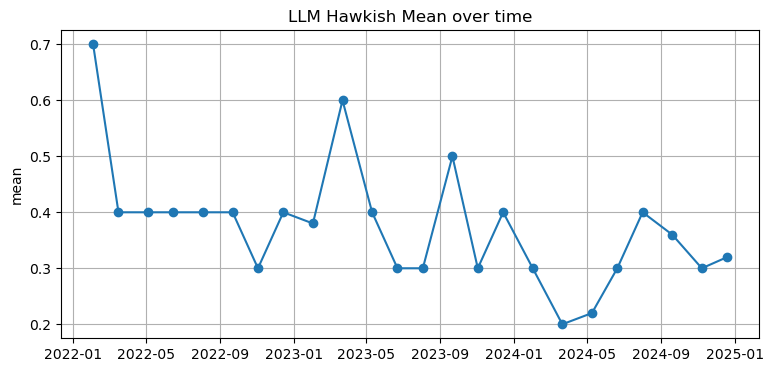

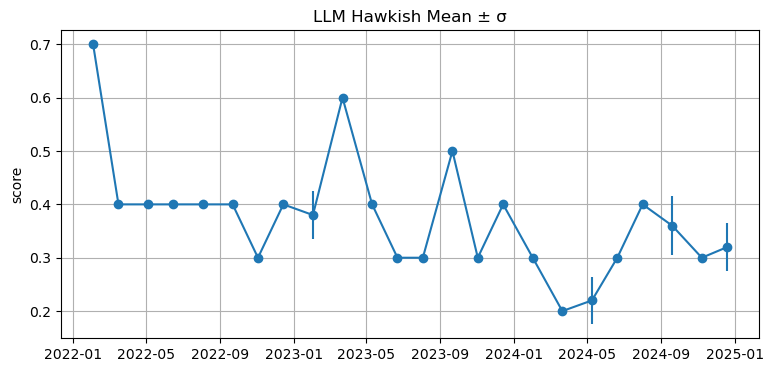

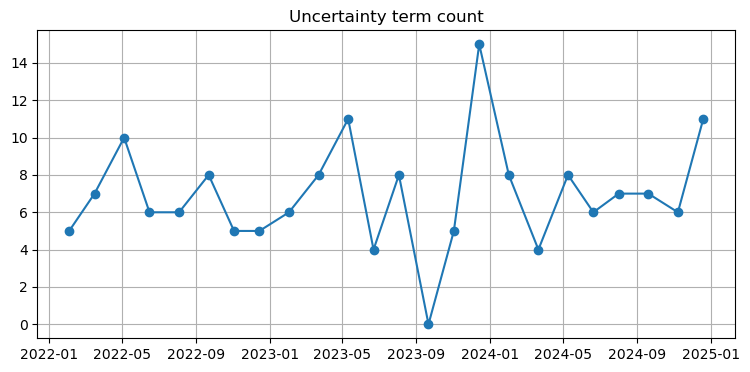

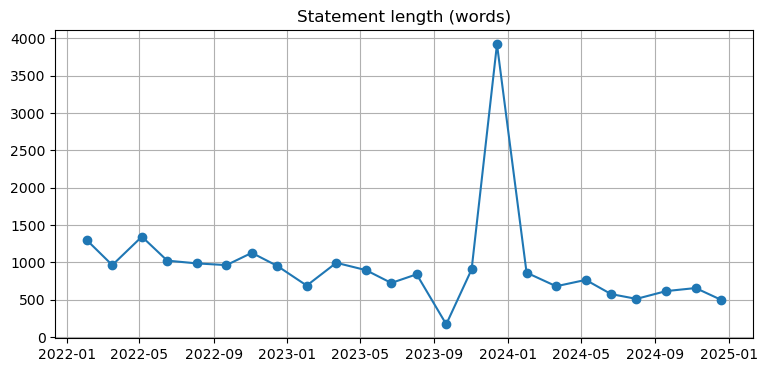

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df["date"], df["mean"], marker="o"); plt.title("Policy Tone (Hawkish–Dovish) over Time"); plt.ylabel("mean"); plt.grid(True); plt.show()
plt.errorbar(df["date"], df["mean"], yerr=df["std"], fmt="o-"); plt.title("LLM Hawkish/Dovish Mean ± σ (Tone & Uncertainty)"); plt.ylabel("score"); plt.grid(True); plt.show()

plt.plot(df["date"], df["uncert_count"], marker="o"); plt.title("Uncertainty term count"); plt.grid(True); plt.show()
plt.plot(df["date"], df["word_count"], marker="o"); plt.title("Statement length (words)"); plt.grid(True); plt.show()


# Insights:

## 1. Policy Tone (Hawkish–Dovish) over Time:
The chart shows that central bank statements started out tough on inflation (hawkish) in early 2022 but gradually became softer and more cautious (dovish) by 2024.
A few brief spikes in 2023 suggest moments when the bank sounded stricter again about controlling prices before easing its tone later.

## 2. LLM Hawkish/Dovish Mean ± σ (Tone & Uncertainty):

The chart shows how the tone of policy statements (hawkish or dovish) changed over time, along with the model’s confidence in those readings.
The small error bars mean the model was quite confident most of the time, while slightly larger bars (like in early 2023 and mid-2024) show mixed or uncertain messaging from the central bank.

## 3. Uncertainty term count:

This chart counts how many times words like “uncertainty,” “risk,” “volatile,” “shock,” or “geopolitical” appeared in each policy statement.
Higher peaks (like around early 2024) mean the central bank’s language showed more concern or caution about the economic outlook — often due to unstable conditions or unclear future signals.

Periods with fewer such terms (like late 2023) indicate greater confidence and stability in policy communication.
So — it’s a proxy for how nervous or confident the policymakers sounded in each meeting.

## 4. Statement length (words):
This chart shows how long each policy statement was over time — basically how much the central bank wrote in each summary.
The sharp spike around late 2023 suggests an unusually long statement, likely when the committee had more complex or uncertain issues to explain.

Shorter statements (like in mid-2024) usually mean clearer, more settled policy direction or fewer new developments to discuss.


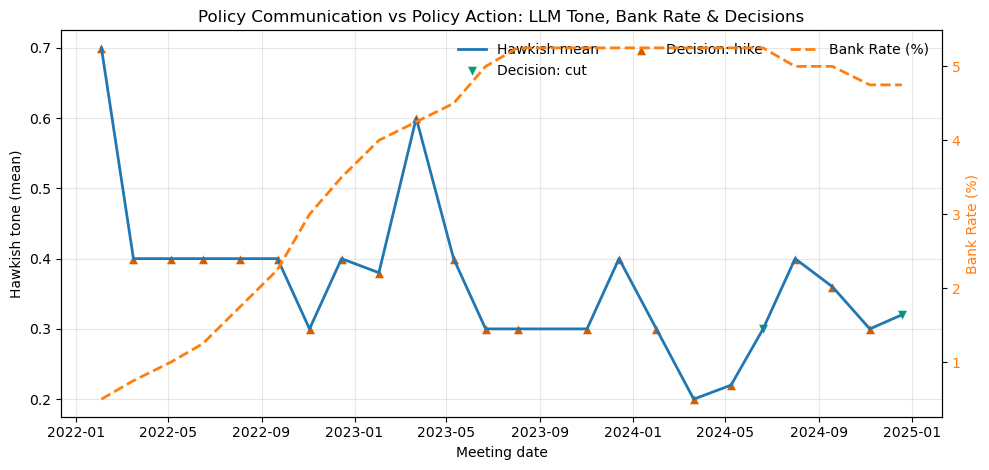

In [53]:
# ==== Combined view: Tone + Bank Rate + Decision coloring ====
import matplotlib.pyplot as plt
import pandas as pd

# keep only rows with both values
d = df.dropna(subset=["mean","bank_rate","decision"]).copy().sort_values("date")

# color/marker map for decisions (color-blind friendly)
cmap   = {"hike":"#D55E00", "hold":"#0072B2", "cut":"#009E73", "unknown":"#999999"}
marks  = {"hike":"^", "hold":"o", "cut":"v", "unknown":"x"}

fig, ax1 = plt.subplots(figsize=(10,4.8))

# 1) Tone (LLM mean) on left y-axis
ax1.plot(d["date"], d["mean"], lw=2, label="Hawkish mean", zorder=2)
ax1.set_ylabel("Hawkish tone (mean)")
ax1.set_xlabel("Meeting date")
ax1.grid(True, alpha=0.3)

# 2) Bank Rate on right y-axis
ax2 = ax1.twinx()
ax2.plot(d["date"], d["bank_rate"], "--", lw=2, label="Bank Rate (%)", color="tab:orange", zorder=1)
ax2.set_ylabel("Bank Rate (%)", color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange")

# 3) Decision-colored scatter on the tone line
for dec, sub in d.groupby("decision"):
    ax1.scatter(sub["date"], sub["mean"],
                s=60, color=cmap.get(dec,"#999999"),
                marker=marks.get(dec,"o"),
                edgecolor="white", linewidth=0.8,
                label=f"Decision: {dec}")

# legends (merge from both axes)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, ncol=3, frameon=False, loc="upper right")

plt.title("Policy Communication vs Policy Action: LLM Tone, Bank Rate & Decisions")
plt.tight_layout()
plt.show()


# Insights
This chart compares what the central bank said (blue line — LLM-measured hawkish/dovish tone) versus what it did (orange line — Bank Rate changes and decision type).

You can see that higher hawkish scores often align with rate hikes, while lower scores come before or during rate cuts.

In other words, the AI model’s tone tracking closely mirrors the bank’s real policy actions — showing that the LLM can effectively detect tightening or easing bias from their communication.

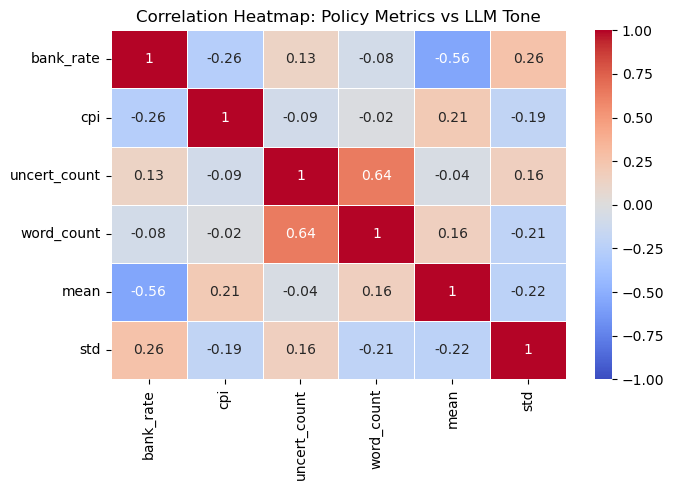

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

num = df[["bank_rate", "cpi", "uncert_count", "word_count", "mean", "std"]]
corr = num.corr().round(2)

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Heatmap: Policy Metrics vs LLM Tone", fontsize=12)
plt.tight_layout()
plt.show()


# Insights:
- Bank Rate and LLM hawkish mean show a strong negative correlation (–0.56) — when tone turns dovish, policy rates tend to fall.
- Uncertainty and word count (0.64) move together — longer statements usually contain more risk-related terms.
- The LLM’s uncertainty (σ) shows weak correlations overall, suggesting the model’s confidence is independent of text length or rate levels.

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=20)
X   = vec.fit_transform(df["text"])
terms = pd.Series(X.toarray().mean(0), index=vec.get_feature_names_out()).sort_values(ascending=False)
print("Top terms:", ", ".join(terms.head(10).index))


Top terms: inflation, policy, monetary, monetary policy, bank, mpc, target, rate, committee, expected


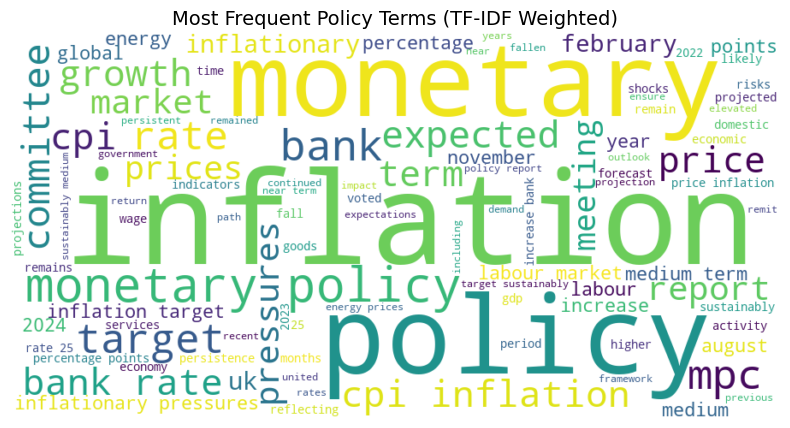

In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# build TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=100)
X = vec.fit_transform(df["text"])
terms = pd.Series(X.toarray().mean(0), index=vec.get_feature_names_out()).sort_values(ascending=False)

# generate word cloud
wc = WordCloud(width=900, height=450, background_color="white", colormap="viridis")
wc.generate_from_frequencies(terms.to_dict())

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Policy Terms (TF-IDF Weighted)", fontsize=14)
plt.show()


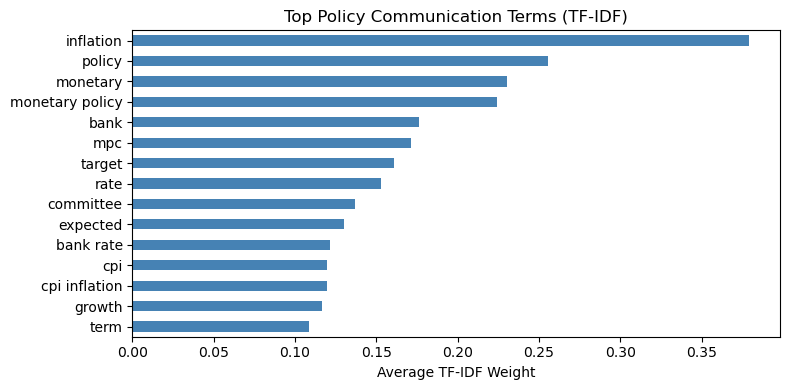

In [59]:
top_terms = terms.head(15)

plt.figure(figsize=(8,4))
top_terms.sort_values().plot(kind="barh", color="steelblue")
plt.xlabel("Average TF-IDF Weight")
plt.title("Top Policy Communication Terms (TF-IDF)")
plt.tight_layout()
plt.show()


The most characteristic language revolves around inflation targeting, monetary policy stance, and expectations management — exactly what we’d expect from MPC summaries. The TF-IDF confirms the LLM is scoring tone on a text base dominated by core policy concepts, not noise.

In [38]:
# # ground_truth: DataFrame with columns ["date","gt_score"] on same scale as df["mean"]
# ground_truth["date"] = pd.to_datetime(ground_truth["date"])
# merged = df.merge(ground_truth, on="date", how="inner")
# mse = ((merged["mean"] - merged["gt_score"])**2).mean()
# print("MSE vs economists:", round(mse, 4))
# plt.scatter(merged["gt_score"], merged["mean"]); plt.plot([0,1],[0,1]); plt.xlabel("GT"); plt.ylabel("LLM mean"); plt.title("Parity: LLM vs Ground truth"); plt.grid(True); plt.show()


# one glance table for the deck.
#### insight: structured, exportable snapshot per meeting.

In [39]:
cols = ["date","decision","bank_rate","cpi","mean","std","uncert_count","word_count"]
display(df[cols].sort_values("date").round(3))


,date,decision,bank_rate,cpi,mean,std,uncert_count,word_count
0,2023-02-02,hike,4.00,10.5,0.38,0.045,6,690
1,2023-03-23,hike,4.25,10.5,0.56,0.089,8,995
2,2023-05-11,hike,4.50,10.2,0.40,0.000,11,897
3,2023-06-22,hike,5.00,10.1,0.30,0.000,4,725
4,2023-08-03,hike,5.25,8.7,0.30,0.000,8,841
5,2023-09-21,unknown,NaN,NaN,0.50,0.000,0,172
6,2023-11-02,hike,5.25,6.7,0.30,0.000,5,906
7,2023-12-14,hike,5.25,3.1,0.40,0.000,15,3920
8,2024-02-01,hike,5.25,4.0,0.30,0.000,8,863
9,2024-03-21,hike,5.25,3.4,0.20,0.000,4,681
